In [40]:
import streamlit as st
from google.cloud import bigquery
from datetime import datetime, timezone
import seaborn as sns
import pandas as pd
import json
import os

In [2]:
BIGQUERY_PROJECT_NAME = 'oso-data-436717'

In [3]:
with open("metrics/defillama.json", "r") as f:
    defi_llama_protocols = json.load(f)

In [4]:
defi_llama_protocols

[{'Ether.fi OP Mainnet LRT Grant': 'ether.fi'},
 {'Expanding restaking on Optimism': 'kelp-dao'},
 {'Renzo Optimism Season 6 Mission Request - Optimism as base for LRTs': 'renzo'},
 {'Boosting LRT adoption with Compound Finance': 'compound-finance'},
 {'TLX - Leveraged Tokens Protocol': 'tlx-finance'},
 {'OETH on OP (2 of 3)': 'origin-protocol'},
 {'Extra Finance S6 Mission Application': 'extra-finance'},
 {"Let's Get HAI": 'lets-get-hai'},
 {'Fraxtal Application': 'frax-finance'},
 {'Derive (Formerly Lyra) Chain - Intent 3B': 'derive'},
 {'Yield Bearing asset utility with Compound': 'compound-finance'},
 {'Beefy - mooBIFI': 'beefy'},
 {'OETH on OP 4': 'origin-protocol'},
 {'Contango ': 'contango'},
 {'Velodrome Finance': 'velodrome'},
 {'Uniswap: YBA Grant': 'uniswap'},
 {'Uniswap: LRT Grant': 'uniswap'},
 {'Idle - Credit Vaults III': 'idle'},
 {'dForce on OP (Resubmission II)': 'dforce'},
 {'Alchemix Grant Request': 'alchemix'},
 {'Toros Finance': 'toros'},
 {'Pyth Network: Infrastru

In [5]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
client = bigquery.Client(BIGQUERY_PROJECT_NAME)

In [6]:
def query_protocol(protocol):
    sql_query = f"""
        select
            name,
            chain_tvls,
            tvl,
            tokens_in_usd,
            tokens,
            current_chain_tvls,
            raises,
            metrics,
            mcap
        from `{BIGQUERY_PROJECT_NAME}.defillama_tvl.{protocol}`
    """

    protocol_result = client.query(sql_query)
    protocol_df = protocol_result.to_dataframe()

    return protocol_df

In [7]:
renzo_df = query_protocol('renzo')

In [8]:
pd.DataFrame(json.loads(renzo_df.iloc[0, 6]))

,amount,category,chains,date,defillamaId,leadInvestors,name,otherInvestors,round,sector,source,valuation
0,NaN,Liquid Staking Protocol,[Ethereum],1708560000,3933,[Binance Labs],Renzo,[],Private,Liquid Restaking Hub,https://x.com/BinanceLabs/status/1760666575508...,None
1,17.0,Liquid Staking Protocol,[Ethereum],1718668800,3933,"[Galaxy, Brevan Howard Digital]",Renzo,"[Maven 11, Figment Capital, Protagonist, Seven...",Private,Liquid Restaking Hub,https://x.com/RenzoProtocol/status/18030401964...,None
2,3.2,Liquid Staking Protocol,[Ethereum],1705276800,3933,[Maven 11],Renzo,"[Figment Capital, SevenX Ventures, IOSG Ventur...",Seed,Liquid Restaking Hub,https://x.com/RenzoProtocol/status/17469418246...,25


In [9]:
alchemix_df = query_protocol('alchemix')

In [10]:
alchemix_df.to_csv('metrics/temp_df.csv', index=False)

In [11]:
alchemix_df.columns

Index(['name', 'chain_tvls', 'tvl', 'tokens_in_usd', 'tokens',
       'current_chain_tvls', 'raises', 'metrics', 'mcap'],
      dtype='object')

In [12]:
alchemix_df

,name,chain_tvls,tvl,tokens_in_usd,tokens,current_chain_tvls,raises,metrics,mcap
0,Alchemix,"{""Arbitrum"":{""tokens"":[{""date"":1719705600,""tok...","[{""date"":1637193600,""totalLiquidityUSD"":797748...","[{""date"":1637193600,""tokens"":{""USDT"":0,""USDC"":...","[{""date"":1637193600,""tokens"":{""USDT"":0,""USDC"":...","{""Arbitrum"":919976.81037,""Ethereum"":54373482.3...",[],{},4.745178e+07


In [13]:
def chain_tvls_col_to_df(df):

    chain_tvls = pd.DataFrame(json.loads(df.iloc[0, 1]))

    def normalize_chain_data(chain_name, chain_data):
        records = []
        for entry in chain_data:
            date = entry["date"]
            for token, value in entry["tokens"].items():
                records.append({"chain": chain_name, "date": date, "token": token, "value": value})
        return pd.DataFrame(records)

    all_chains_data = []
    for chain in chain_tvls.columns:
        chain_data = chain_tvls[chain].iloc[0]
        normalized_data = normalize_chain_data(chain, chain_data)
        all_chains_data.append(normalized_data)

    cleaned_df = pd.concat(all_chains_data, ignore_index=True)

    cleaned_df['readable_date'] = cleaned_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return cleaned_df

In [14]:
chain_tvls = chain_tvls_col_to_df(alchemix_df)

In [15]:
def tvl_col_to_df(df):
    # extract tvl data
    tvl_df = pd.DataFrame(json.loads(df.iloc[0, 2]))
    
    # convert timestamp to a human-readable date
    tvl_df['readable_date'] = tvl_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return tvl_df

In [16]:
tvl = tvl_col_to_df(alchemix_df)

In [17]:
def tokens_in_usd_col_to_df(df):
    # extract tokens_in_usd data from the column
    tokens_data = pd.DataFrame(json.loads(df.iloc[0, 3]))

    # flatten the tokens dictionary for each date
    records = []
    for _, row in tokens_data.iterrows():
        date = row["date"]
        tokens = row["tokens"]
        for token, value in tokens.items():
            records.append({"date": date, "token": token, "value": value})

    # create a DataFrame from the flattened records
    tokens_df = pd.DataFrame(records)

    # convert timestamp to a human-readable date
    tokens_df['readable_date'] = tokens_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return tokens_df

In [18]:
tokens_in_usd = tokens_in_usd_col_to_df(alchemix_df)

In [19]:
def tokens_col_to_df(df):
    # extract tokens data from the column
    tokens_data = pd.DataFrame(json.loads(df.iloc[0, 4]))

    # flatten the tokens dictionary for each date
    records = []
    for _, row in tokens_data.iterrows():
        date = row["date"]
        tokens = row["tokens"]
        for token, value in tokens.items():
            records.append({"date": date, "token": token, "value": value})

    # create a DataFrame from the flattened records
    tokens_df = pd.DataFrame(records)

    # convert timestamp to a human-readable date
    tokens_df['readable_date'] = tokens_df['date'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )

    return tokens_df

In [20]:
tokens = tokens_col_to_df(alchemix_df)

In [21]:
print(chain_tvls.columns)
print(tvl.columns)
print(tokens_in_usd.columns)
print(tokens.columns)

Index(['chain', 'date', 'token', 'value', 'readable_date'], dtype='object')
Index(['date', 'totalLiquidityUSD', 'readable_date'], dtype='object')
Index(['date', 'token', 'value', 'readable_date'], dtype='object')
Index(['date', 'token', 'value', 'readable_date'], dtype='object')


In [22]:
chain_tvls['token'].value_counts()

token
DAI         2636
ALCX        2270
WETH        2135
USDT        1835
USDC        1622
WSTETH      1489
RETH        1129
YVDAI        953
YVUSDC       879
YVUSDT       722
YVWETH       700
AOPTWETH     696
AOPTUSDT     696
AOPTUSDC     696
AOPTDAI      696
3CRV         586
USDC.E       430
CRVFRAX      301
VAUSDC       177
VAFRAX       177
VAETH        177
VADAI        177
SFRXETH      177
TWETH         71
FUSDT         23
ETH           14
Name: count, dtype: int64

In [23]:
selected_token = st.selectbox("Select a Token", chain_tvls['token'].unique())

pivoted_chain_tvls = pd.pivot(chain_tvls[chain_tvls['token'] == selected_token], index='readable_date', columns='chain', values='value')

st.line_chart(pivoted_chain_tvls)

2024-12-25 20:35:32.649 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.650 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.652 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.653 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-25 20:35:32.654 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2024-12-25 20:35:32.655 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

DeltaGenerator()

In [24]:
chain_tvls[chain_tvls['token'] == "ETH"]

,chain,date,token,value,readable_date
14239,Optimism,1667952000,ETH,8.69234,2022-11-09 00:00:00
14244,Optimism,1668038400,ETH,8.79216,2022-11-10 00:00:00
14249,Optimism,1668124800,ETH,8.80404,2022-11-11 00:00:00
14254,Optimism,1668211200,ETH,8.80404,2022-11-12 00:00:00
14259,Optimism,1668297600,ETH,9.44705,2022-11-13 00:00:00
14264,Optimism,1668384000,ETH,9.44705,2022-11-14 00:00:00
14269,Optimism,1668470400,ETH,9.49855,2022-11-15 00:00:00
14274,Optimism,1668556800,ETH,9.51061,2022-11-16 00:00:00
14279,Optimism,1668643200,ETH,9.51061,2022-11-17 00:00:00
14284,Optimism,1668729600,ETH,9.81061,2022-11-18 00:00:00


In [25]:
import matplotlib.pyplot as plt

In [27]:
%matplotlib inline

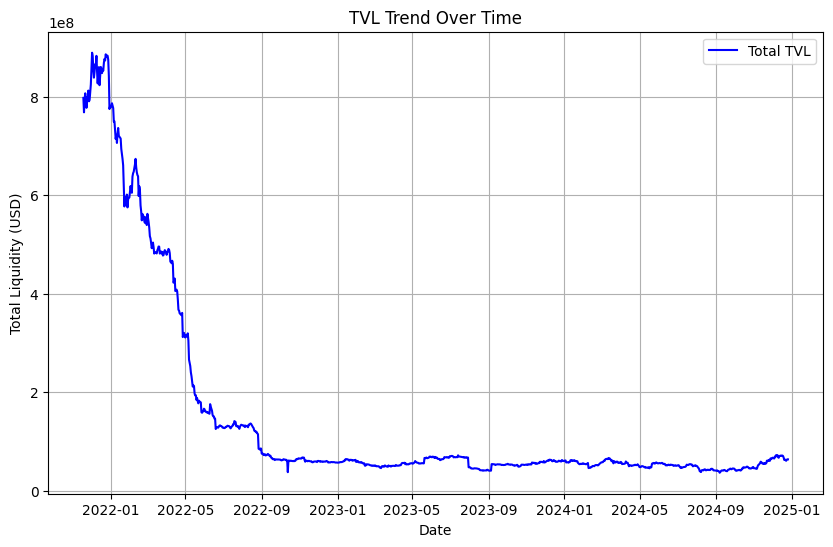

In [29]:
# Load and preprocess data
tvl['readable_date'] = pd.to_datetime(tvl['readable_date'])
tvl = tvl.sort_values(by='readable_date')

# Plot TVL trend over time
plt.figure(figsize=(10, 6))
plt.plot(tvl['readable_date'], tvl['totalLiquidityUSD'], label='Total TVL', color='blue')
plt.title('TVL Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Liquidity (USD)')
plt.legend()
plt.grid()
plt.show()

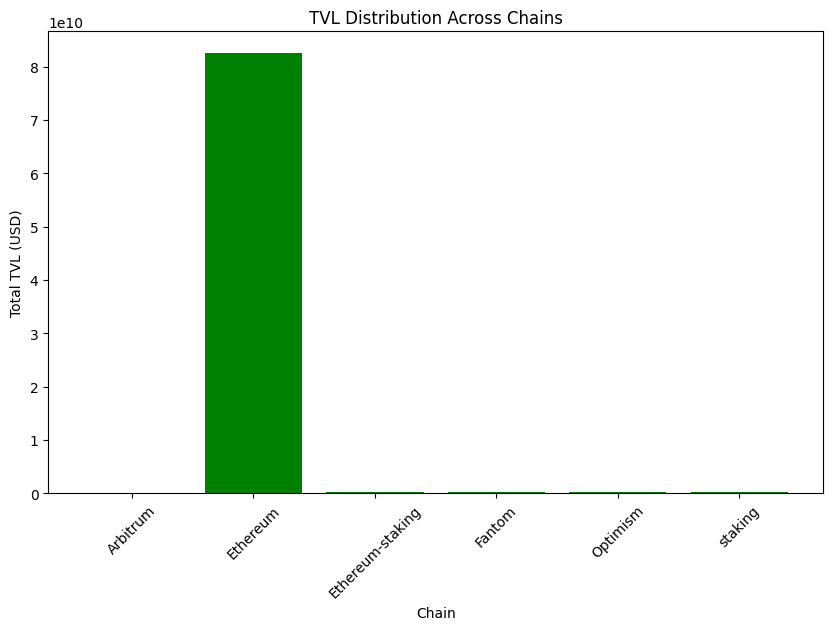

In [30]:
# Aggregate TVL by chain
chain_tvl_summary = chain_tvls.groupby('chain')['value'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(chain_tvl_summary['chain'], chain_tvl_summary['value'], color='green')
plt.title('TVL Distribution Across Chains')
plt.xlabel('Chain')
plt.ylabel('Total TVL (USD)')
plt.xticks(rotation=45)
plt.show()


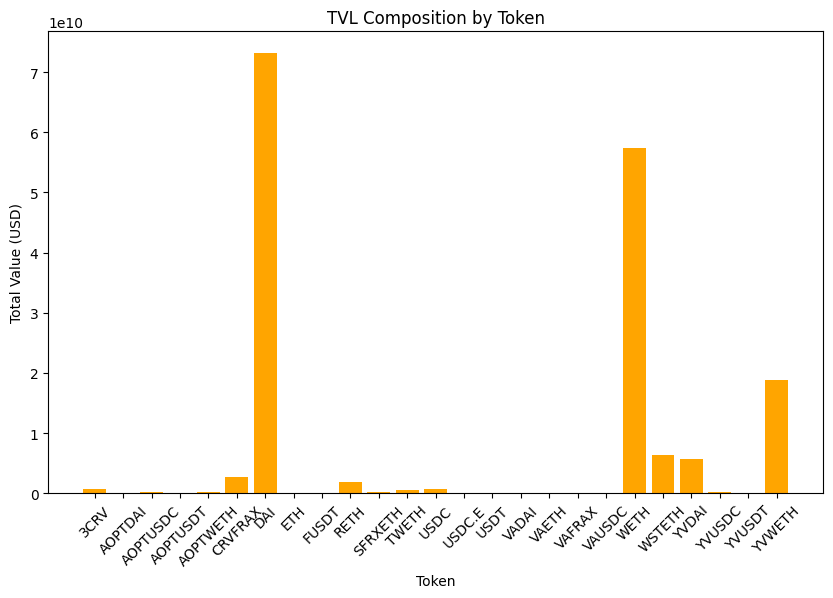

In [31]:
# Aggregate TVL by token
token_tvl_summary = tokens_in_usd.groupby('token')['value'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(token_tvl_summary['token'], token_tvl_summary['value'], color='orange')
plt.title('TVL Composition by Token')
plt.xlabel('Token')
plt.ylabel('Total Value (USD)')
plt.xticks(rotation=45)
plt.show()

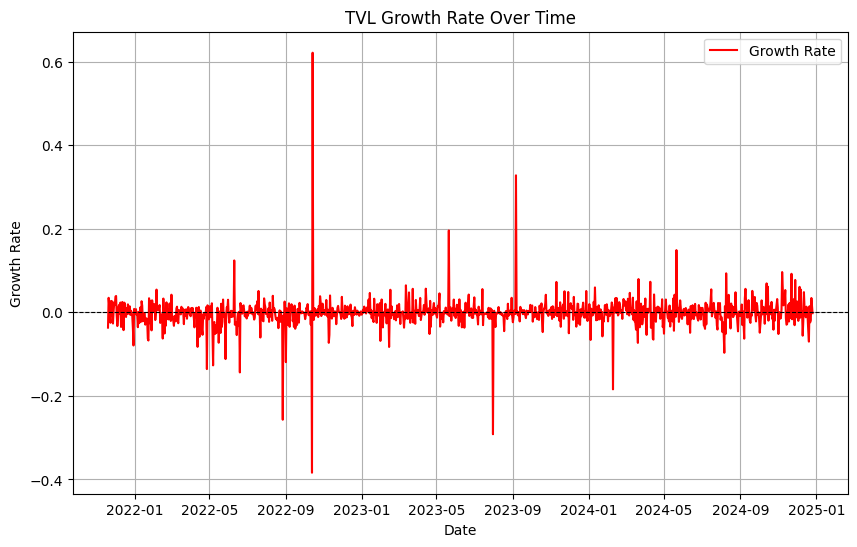

In [32]:
# Calculate growth rate
tvl['tvl_diff'] = tvl['totalLiquidityUSD'].diff()
tvl['tvl_growth_rate'] = tvl['tvl_diff'] / tvl['totalLiquidityUSD'].shift(1)

# Plot TVL growth rate
plt.figure(figsize=(10, 6))
plt.plot(tvl['readable_date'], tvl['tvl_growth_rate'], label='Growth Rate', color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('TVL Growth Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Growth Rate')
plt.legend()
plt.grid()
plt.show()

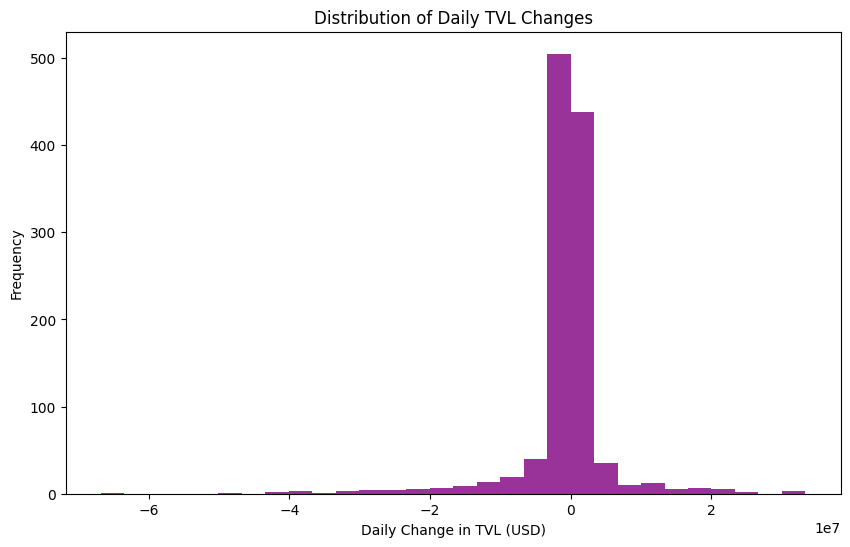

In [34]:
# Calculate daily TVL changes
tvl['tvl_diff'] = tvl['totalLiquidityUSD'].diff()

# Plot histogram of daily changes
plt.figure(figsize=(10, 6))
plt.hist(tvl['tvl_diff'].dropna(), bins=30, color='purple', alpha=0.8)
plt.title('Distribution of Daily TVL Changes')
plt.xlabel('Daily Change in TVL (USD)')
plt.ylabel('Frequency')
plt.show()

In [43]:
chain_tvls

,chain,date,token,value,readable_date
0,Arbitrum,1719705600,USDC,313.57898,2024-06-30 00:00:00
1,Arbitrum,1719705600,WETH,1.42010,2024-06-30 00:00:00
2,Arbitrum,1719792000,USDC,34.75763,2024-07-01 00:00:00
3,Arbitrum,1719792000,WETH,1.42010,2024-07-01 00:00:00
4,Arbitrum,1719878400,USDC,125.93226,2024-07-02 00:00:00
...,...,...,...,...,...
21459,staking,1734825600,ALCX,275590.34822,2024-12-22 00:00:00
21460,staking,1734912000,ALCX,275359.25329,2024-12-23 00:00:00
21461,staking,1734998400,ALCX,275159.25329,2024-12-24 00:00:00
21462,staking,1735084800,ALCX,275063.86319,2024-12-25 00:00:00


In [59]:
chain_tvls['daily_change'] = chain_tvls.groupby(['chain', 'token'])['value'].diff()
chain_tvls.dropna(subset='daily_change', inplace=True)

In [60]:
chain_tvls

,chain,date,token,value,readable_date,daily_change
6,Arbitrum,1719964800,USDC,232.60691,2024-07-03 00:00:00,106.67465
7,Arbitrum,1719964800,WETH,1.49977,2024-07-03 00:00:00,0.00000
9,Arbitrum,1720051200,USDC,232.60691,2024-07-04 00:00:00,0.00000
10,Arbitrum,1720051200,WETH,1.49977,2024-07-04 00:00:00,0.00000
12,Arbitrum,1720137600,USDC,326.86548,2024-07-05 00:00:00,94.25857
...,...,...,...,...,...,...
21459,staking,1734825600,ALCX,275590.34822,2024-12-22 00:00:00,-33.39919
21460,staking,1734912000,ALCX,275359.25329,2024-12-23 00:00:00,-231.09493
21461,staking,1734998400,ALCX,275159.25329,2024-12-24 00:00:00,-200.00000
21462,staking,1735084800,ALCX,275063.86319,2024-12-25 00:00:00,-95.39010


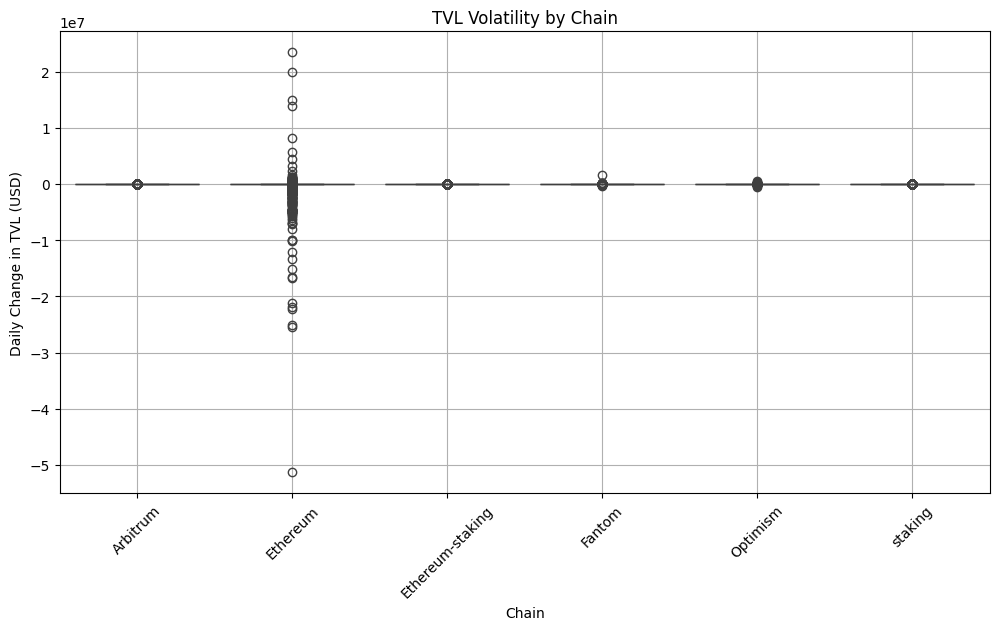

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=chain_tvls, x='chain', y='daily_change')
plt.title('TVL Volatility by Chain')
plt.xlabel('Chain')
plt.ylabel('Daily Change in TVL (USD)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
last_day = datetime(2024, 8, 31)
tvl_last_day = tvl[tvl['readable_date'] == last_day]

